In [1]:
import pandas as pd
import numpy as np
import requests
from matplotlib import pyplot as plt
%matplotlib inline
import time # NB: Use to limit rate of making requests to a website
from bs4 import BeautifulSoup
#from selenium import webdriver
import re # regex 
print('Libraries loaded.')

Libraries loaded.


In [2]:
#extract rows describing windmills
#and drop everything before latitude info
#since pandas has trouble parsing it, and we don't need it
with open("data/06-CA-noheader.Dat",'r') as f:
    lines = f.readlines()
trunc_lines = [s[35:] for s in lines if ("WINDMILL" in s)]
with open("data/06-CA-noloc.Dat",'w') as f:
    f.writelines(trunc_lines)

In [3]:
df = pd.read_table("data/06-CA-noloc.Dat", sep="\s+",
                   usecols=range(6),
                   header=None)
df.columns = ['lat_deg','lat_min','lat_sec','lon_deg','lon_min','lon_sec']


for c, cs in zip(['lat_sec','lon_sec'],['lat_sign','lon_sign']):
    #convert cardinal direction to decimal degree sign
    #for north america these will be the same for all rows (N,W)
    df[cs] = df[c].apply(lambda s: 
                        {'N' : 1, 'S' : -1, 'E' : 1, 'W' : -1}[s[-1]]
                        )
    #drop N, W markers
    df[c] = df[c].apply(lambda s: s[:-1])
    
#convert to float
for c in df.columns:
    df[c] = df[c].astype(np.float)

df

,lat_deg,lat_min,lat_sec,lon_deg,lon_min,lon_sec,lat_sign,lon_sign
0,32.0,42.0,5.40,116.0,21.0,4.80,1.0,-1.0
1,32.0,42.0,8.66,116.0,19.0,33.40,1.0,-1.0
2,32.0,42.0,12.75,116.0,19.0,37.80,1.0,-1.0
3,32.0,42.0,16.95,116.0,19.0,42.01,1.0,-1.0
4,32.0,42.0,21.19,116.0,19.0,46.20,1.0,-1.0
...,...,...,...,...,...,...,...,...
2529,40.0,54.0,34.10,121.0,48.0,59.45,1.0,-1.0
2530,40.0,54.0,36.15,121.0,49.0,9.03,1.0,-1.0
2531,40.0,54.0,39.10,121.0,49.0,18.73,1.0,-1.0
2532,40.0,54.0,45.68,121.0,49.0,24.55,1.0,-1.0


In [6]:
def to_dec_coords(sign,degree,minute,second):
    return sign*(degree + minute/60 + second/(60*60))

df['latitude'] = to_dec_coords(df['lat_sign'],df['lat_deg'],df['lat_min'],df['lat_sec'])
df['longitude'] = to_dec_coords(df['lon_sign'],df['lon_deg'],df['lon_min'],df['lon_sec'])

In [4]:
import geopandas as gpd
usa = gpd.read_file('maps/states_21basic/states.shp')

In [53]:
from shapely.geometry import Point
import geopandas as gpd
turbine_points = [Point(xy) for xy in zip(df['longitude'],df['latitude'])]
#crs = {'init' : 'epsg:4326'}
crs = usa.crs
turbine_df = gpd.GeoDataFrame(df, crs = crs, geometry = turbine_points)

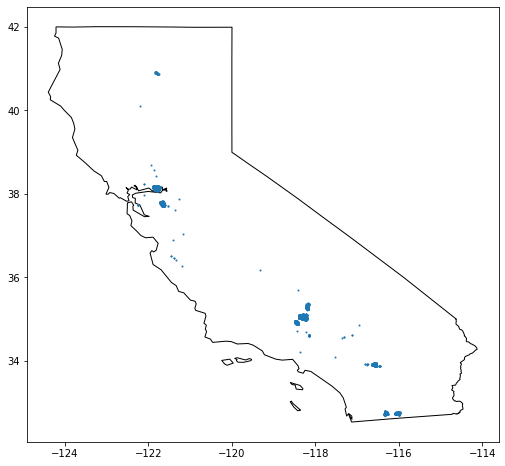

In [8]:
fig, ax = plt.subplots(figsize=(15,8))
#plot california
base = usa[usa.STATE_ABBR == 'CA'].plot(color='white',edgecolor='black',ax=ax)
#plot turbine locations
turbine_df.plot(ax=ax,markersize=1)

In [184]:
#plant_gen = pd.read_excel('data/2018_Quarterly_Wind_Production.xlsx')
plant_gen = pd.read_csv('data/cal-power-gen-19.csv', thousands=',')

In [185]:
plant_gen

,Year,Company Name,EIA\nPlant ID,CEC\nPlant ID,Plant Name,State,Capacity (MW),Gross MWh,Net MWh
0,2019.0,Alta Wind VIII LLC,57835,W0393,"Alta Wind VIII, LLC",CA,150.0,237116,237116
1,2019.0,BP Wind Energy North America,50553,W0391,"Edom Hills Project 1, LLC",CA,20.0,28500,28500
2,2019.0,CalWind Resources Inc,10191,W0284,Wind Resource I (Calwind Wind Resource I),CA,8.7,14038,14038
3,2019.0,CalWind Resources Inc,54909,W0320,Wind Resource II (Calwind),CA,20.0,47619,47619
4,2019.0,Coram California Development LP,57962,W0408,"Coram California Development, LP",CA,102.0,247038,247038
...,...,...,...,...,...,...,...,...,...
112,2019.0,Terra-Gen Operating Company,57834,W0415,Pinyon Pines Winds I,CA,168.0,275334,275334
113,2019.0,Terra-Gen Operating Company,57837,W0416,Pinyon Pines Winds II,CA,132.0,213748,213748
114,2019.0,Windpower Partners 1993 LP,50276,W0318,"Wintec Energy, Ltd.",CA,2.2,71,71
115,2019.0,Windstar Energy LLC,57774,W0419,"Windstar Energy, LLC",CA,120.0,267298,267298


In [71]:
#usa_turbines = gpd.read_file('data/OnshoreIndustri/USGS_windturbine_201307.shp')

In [257]:
usa_turbines = pd.read_csv('data/uswtdbCSV/uswtdb_v3_0_1_20200514.csv')
ca_turbines = usa_turbines[usa_turbines.t_state == 'CA']
points = [Point(xy) for xy in zip(ca_turbines['xlong'],ca_turbines['ylat'])]

In [260]:
ca_turbines['points'] = points

/Users/kook/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [224]:
names = [
    ['Alta','VIII'],
    ['Edom'],
    ['Coram','Energy'],
    #['Wintec'],
    ['Windstar'],
    #['Pinyon',' I'],
    ['Pinyon','II'],
    ['Mojave 16'],
    ['Ocotillo'],
    ['Manzana'],
    ['High'],
    ['North Sky'],
    #['Golden Hills'],
    #['Dutch']
]

In [220]:
plant_gen.sort_values(['Capacity (MW)'],ascending=False).iloc[:20]

,Year,Company Name,EIA\nPlant ID,CEC\nPlant ID,Plant Name,State,Capacity (MW),Gross MWh,Net MWh
116,NaN,NaN,NaN,NaN,NaN,Total,5973.1,13685668,13679552
55,2019.0,Pettern Energy (Ocotillo LLC),57514,W0409,Ocotillo Express LLC,CA,265.4,594610,594610
74,2019.0,See WPRS for details,Missing,W0420,Manzana Wind,CA,189.0,490645,490645
112,2019.0,Terra-Gen Operating Company,57834,W0415,Pinyon Pines Winds I,CA,168.0,275334,275334
110,2019.0,Terra-Gen Operating Company,57294,W0389,Alta V Wind Energy Center,CA,168.0,253993,253993
64,2019.0,Seawest Energy Group,56075,W0355,High Winds,CA,162.0,264416,264416
36,2019.0,North Sky River Energy LLC,58121,W0414,"North Sky River, LLC",CA,162.0,430471,430471
101,2019.0,Shiloh III Wind Project,56874,W0384,"Shiloh Wind Project 2, LLC (Shiloh II & III)",CA,153.8,383508,383508
23,2019.0,FPL Energy Operating Services Inc,55152,W0358,Shiloh I Wind (Victory Garden Prtnr PHIV),CA,150.0,381867,381867
108,2019.0,Terra-Gen Operating Company,57292,W0387,Alta III Wind Energy Center,CA,150.0,316458,316458


In [123]:
def vec_str_in(s_arr,s_match):
    return [s_match in str(s) for s in s_arr]
def vec_all_str_in(s_arr,s_match_list):
    return [np.all([s_match in str(s) for s_match in s_match_list]) for s in s_arr]

In [225]:
plant_gen[vec_all_str_in(plant_gen['Plant Name'].to_numpy(),names[-1])]

,Year,Company Name,EIA\nPlant ID,CEC\nPlant ID,Plant Name,State,Capacity (MW),Gross MWh,Net MWh
36,2019.0,North Sky River Energy LLC,58121,W0414,"North Sky River, LLC",CA,162.0,430471,430471


In [226]:
#check if list of strings in name identify a unique plant
print([np.count_nonzero(vec_all_str_in(plant_gen['Plant Name'].to_numpy(),name)) for name in names])
#make sure 'names' specifies unique names in ca_turbines
print([np.count_nonzero(vec_all_str_in(ca_turbines['p_name'].unique(),name)) for name in names])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [227]:
#filter out plants of interest
names_plant_gen = pd.concat([plant_gen[vec_all_str_in(plant_gen['Plant Name'].to_numpy(),name)] for name in names],axis=0).reset_index()
names_plant_gen

,index,Year,Company Name,EIA\nPlant ID,CEC\nPlant ID,Plant Name,State,Capacity (MW),Gross MWh,Net MWh
0,0,2019.0,Alta Wind VIII LLC,57835,W0393,"Alta Wind VIII, LLC",CA,150.0,237116,237116
1,1,2019.0,BP Wind Energy North America,50553,W0391,"Edom Hills Project 1, LLC",CA,20.0,28500,28500
2,98,2019.0,See WPRS for details,Missing,W0463,Coram Energy LLC,CA,15.0,46309,46309
3,115,2019.0,Windstar Energy LLC,57774,W0419,"Windstar Energy, LLC",CA,120.0,267298,267298
4,113,2019.0,Terra-Gen Operating Company,57837,W0416,Pinyon Pines Winds II,CA,132.0,213748,213748
5,31,2019.0,Mojave 16/17/18 LLC,50822,W0313,"Mojave 16, 17, 18 (Mojave 16-17-18 (Desertwind...",CA,83.6,101245,101245
6,55,2019.0,Pettern Energy (Ocotillo LLC),57514,W0409,Ocotillo Express LLC,CA,265.4,594610,594610
7,74,2019.0,See WPRS for details,Missing,W0420,Manzana Wind,CA,189.0,490645,490645
8,64,2019.0,Seawest Energy Group,56075,W0355,High Winds,CA,162.0,264416,264416
9,36,2019.0,North Sky River Energy LLC,58121,W0414,"North Sky River, LLC",CA,162.0,430471,430471


In [269]:

def MWh_per_year_to_MW(x):
    return 1.142e-4*x
names_plant_gen['mean MW'] = pd.to_numeric(names_plant_gen['Gross MWh']).apply(MWh_per_year_to_MW)
names_plant_gen['cap_frac'] = names_plant_gen['mean MW']/names_plant_gen['Capacity (MW)']
names_plant_gen[['Plant Name','Capacity (MW)','Gross MWh','mean MW','cap_frac']].head()

,Plant Name,Capacity (MW),Gross MWh,mean MW,cap_frac
0,"Alta Wind VIII, LLC",150.0,237116,27.078647,0.180524
1,"Edom Hills Project 1, LLC",20.0,28500,3.254700,0.162735
2,Coram Energy LLC,15.0,46309,5.288488,0.352566
3,"Windstar Energy, LLC",120.0,267298,30.525432,0.254379
4,Pinyon Pines Winds II,132.0,213748,24.410022,0.184924


In [85]:
#for comparing plant name formats
plant_gen['Plant Name']
ca_turbines['p_name'].unique()

array(['251 Wind', 'Alite Wind Farm', 'Alta I', 'Alta II', 'Alta III',
       'Alta IV', 'Alta Mesa', 'Alta Mesa 1 and 2', 'Alta V',
       'Alta VI (partial)', 'Alta VIII (partial)', 'Alta X', 'Alta XI',
       'Altech III', 'Anheuser-Busch Fairfield',
       'Barstow Marine Logistics Base', 'Brookfield Tehachapi 1 (CCDLP)',
       'Brookfield Tehachapi 2', 'Brookfield Tehachapi 3', 'Buena Vista',
       'Cabazon', 'California State Prison Los Angeles County',
       'Cameron Ridge', 'Cemex Black Mountain Quarry', 'Cemex Madison',
       'Cemex River Plant', 'City of Soledad Water Reclamation Facility',
       'Coram Energy LLC', 'Correctional Training Facility',
       'Desert Hot Springs', 'Diablo Winds', 'Difwind 1', 'Difwind 2',
       'Difwind 5', 'Difwind 6', 'Dillon', 'Dinosaur Point',
       'Dutch Energy', 'EUI Management', 'East Winds',
       'Edom Hills (repower)', 'Enron Earth Smart/Green Power',
       'Garnet Wind Project', 'Golden Acorn Casino', 'Golden Hills',
       

In [229]:
#count turbines for each plant specified by 'names'
n_turbines = [np.count_nonzero(vec_all_str_in(ca_turbines['p_name'].to_numpy(),name)) for name in names]
n_turbines

[58, 8, 8, 60, 37, 288, 112, 126, 90, 100]

In [230]:
#take a turbine representative from each plant
turbine_rep = pd.concat([ca_turbines[vec_all_str_in(ca_turbines['p_name'].to_numpy(),name)].iloc[0:1] for name in names],axis=0).reset_index()
turbine_rep

,index,case_id,faa_ors,faa_asn,usgs_pr_id,eia_id,t_state,t_county,t_fips,p_name,...,t_hh,t_rd,t_rsa,t_ttlh,t_conf_atr,t_conf_loc,t_img_date,t_img_srce,xlong,ylat
0,937,3044800,06-023316,2012-WTW-7613-OE,7025.0,57833.0,CA,Kern County,6029,Alta VIII (partial),...,80.0,90.0,6361.73,125.0,3,3,11/9/2016,Digital Globe,-118.220291,35.027294
1,15258,3029382,06-021361,2008-WTW-7296-OE,13520.0,50553.0,CA,Riverside County,6065,Edom Hills (repower),...,80.0,93.0,6792.91,126.5,3,3,1/1/2012,NAIP,-116.461586,33.878494
2,12513,3014653,06-020372,2003-AWP-4063-OE,2651.0,54298.0,CA,Kern County,6029,Coram Energy LLC,...,NaN,NaN,NaN,NaN,2,3,1/1/2012,NAIP,-118.324791,35.065594
3,59078,3036668,06-021906,2013-WTW-8530-OE,2404.0,57774.0,CA,Kern County,6029,Windstar,...,67.0,80.0,5026.55,107.0,3,3,7/31/2016,Digital Globe,-118.279320,35.026024
4,42025,3044833,06-023339,2012-WTW-7650-OE,7042.0,57292.0,CA,Kern County,6029,Pinyon Pines II,...,80.0,90.0,6361.73,125.0,3,3,1/1/2013,Digital Globe,-118.211388,35.010696
5,34886,3010060,NaN,NaN,4187.0,50821.0,CA,Kern County,6029,"Mojave 16, 17 & 18 (Desertwind III PPC Tru",...,NaN,NaN,NaN,NaN,1,3,11/3/2018,Digital Globe,-118.257889,35.041794
6,38139,3044761,06-027431,2019-WTW-814-OE,16463.0,57514.0,CA,Imperial County,6025,Ocotillo Wind I,...,80.0,108.0,9160.88,134.1,3,3,1/10/2018,Digital Globe,-116.056389,32.766495
7,31692,3037103,06-023004,2010-WTW-7615-OE,6242.0,57484.0,CA,Kern County,6029,Manzana Winds,...,65.0,77.0,4656.63,103.6,3,3,1/1/2012,NAIP,-118.470688,34.917397
8,23005,3013695,06-020699,2002-AWP-3787-OE,13093.0,56075.0,CA,Solano County,6095,High Winds,...,60.0,80.0,5026.55,100.0,3,3,1/1/2012,NAIP,-121.810890,38.140095
9,37384,3045691,06-025174,2012-WTW-9930-OE,7176.0,58154.0,CA,Kern County,6029,North Sky River,...,80.0,100.0,7853.98,130.1,3,3,10/11/2019,Digital Globe,-118.180984,35.368095


In [231]:
#make points for checking wind poly
turbine_rep['points'] = [Point(xy) for xy in zip(turbine_rep['xlong'],turbine_rep['ylat'])]
#append capacity fraction output for plant
turbine_rep['cap_frac'] = names_plant_gen['cap_frac'].to_numpy()

In [31]:
wind = gpd.read_file('data/californiawindhighresolution/ca_50mwind.shx')

In [232]:
turbine_gridcodes = []
turbine_poly = []
for i,p in enumerate(turbine_rep['points']):
    if i%10 == 0:
        print(i)
    for gc, poly in zip(wind['GRIDCODE'],wind['geometry']):
        if p.within(poly):
            turbine_poly.append(poly)
            turbine_gridcodes.append(gc)
            break

0


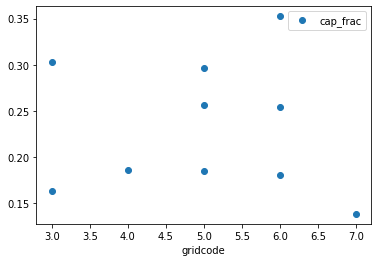

In [233]:
turbine_rep['gridcode'] = turbine_gridcodes
turbine_rep.plot(x='gridcode',y='cap_frac',linestyle='',marker='o')

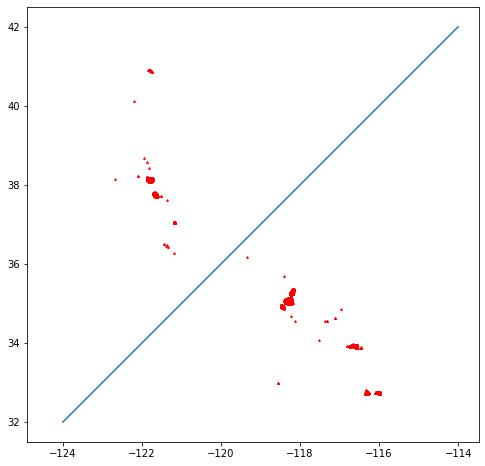

In [266]:
fig, ax = plt.subplots(figsize=(15,8))
#plot california
#turbine_df = gpd.GeoDataFrame(turbine_rep, crs = usa.crs, geometry = turbine_rep['points'])
turbine_df = gpd.GeoDataFrame(ca_turbines, geometry = points)
#plot turbine locations
#wind_plot = wind.iloc[::].plot(column='GRIDCODE',ax=ax)
base = usa[usa.STATE_ABBR == 'CA'].plot(facecolor="none",edgecolor='white',ax=ax)
#fig.colorbar(im,ax=ax)
#turbine_df.plot(ax=ax,markersize=3,marker='^',column='cap_frac',cmap='gist_rainbow')
turbine_df.plot(ax=ax,markersize=3,marker='^',color='red')
#plt.plot([-124,-114],[32,42]) #check aspect
ax.set_aspect(1)
#plt.savefig('cal-wind-fig.png', bbox_inches = 'tight',pad_inches = 0)

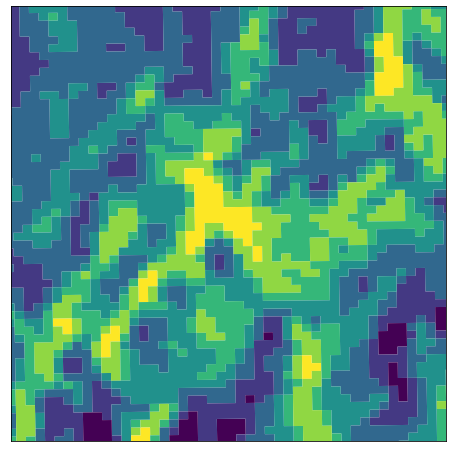

In [279]:
fig, ax = plt.subplots(figsize=(8,8))
wind_plot = wind.iloc[::].plot(column='GRIDCODE',ax=ax,cmap='viridis')
ax.set_xlim(-118.25,-118.15)
ax.set_ylim(35.25,35.35)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('wind-app-demo.png', bbox_inches = 'tight',pad_inches = 0 )

In [47]:
wind['geometry']

0         POLYGON ((-124.19627 41.99373, -124.20106 41.9...
1         POLYGON ((-124.15334 41.99823, -124.15095 41.9...
2         POLYGON ((-124.13377 41.99585, -124.13857 41.9...
3         POLYGON ((-124.13138 41.99600, -124.13377 41.9...
4         POLYGON ((-124.12898 41.99615, -124.13138 41.9...
                                ...                        
197429    POLYGON ((-117.04252 32.36595, -117.04464 32.3...
197430    POLYGON ((-116.98087 32.36595, -116.98087 32.3...
197431    POLYGON ((-116.98937 32.36415, -116.99575 32.3...
197432    POLYGON ((-117.05952 32.35872, -117.06377 32.3...
197433    POLYGON ((-117.24027 32.38377, -117.24029 32.3...
Name: geometry, Length: 197434, dtype: geometry

In [46]:
geometry[0].within(wind['geometry'][0])

False

(32.6, 32.8)

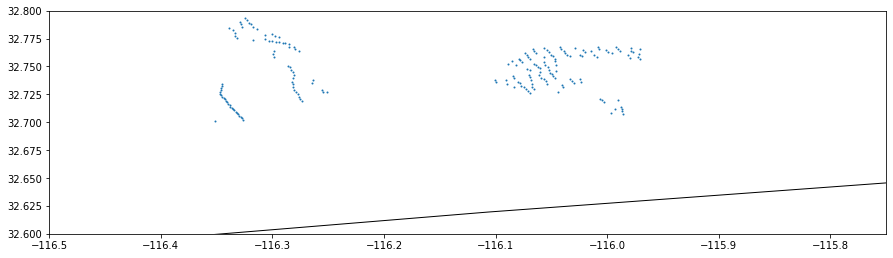

In [63]:
fig, ax = plt.subplots(figsize=(15,8))
#plot california
base = usa[usa.STATE_ABBR == 'CA'].plot(color='white',edgecolor='black',ax=ax)
#plot turbine locations
turbine_df.plot(ax=ax,markersize=1)
ax.set_xlim(-116.5,-115.75)
ax.set_ylim(32.6,32.8)